### Implementing K-means clustering to find an optimal location to open an exclusive gym at Manhattan,NY

##### This project is part of IBM Data Science Capstone project

### Introduction:
##### Starting a new business can be very exciting but also risky. There are many factors that needs to be taken into consideration for success of a new business such are: location, competition, safety. Purpose of this project is to find an optimal location for opening an exclusive gym at Manhattan, NY. To answer the question to a client who is seeking the best area to open a new exclusive gym we have to determine which neighborhoods are considered to be safe but also with high income, and we will need to look into competitions since we want to find an area that is not very competitive which will increase chance of business success. 


In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd 
import json # library to handle JSON files
#!pip install censusdata
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
! pip install geopandas
import geopandas as gpd
import geopy
import warnings
warnings.filterwarnings('ignore')
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
import tqdm
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
!pip install beautifulsoup4 #web scraping of table from the Wikipedia
!pip install lxml
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
from collections import Counter
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
from IPython.display import display_html
from functools import reduce
print('Libraries imported.')

Libraries imported.


### Data
#### Following dataset were used in this project:
##### 1.NYC census to determine neighborhoods with high income
##### 2.NYPD arrests to determine the safest neighborhoods
##### 3.NYC borough and neighborhood data with Latitude and Longitude
##### 4.Venues data was obtained from Foursquare API


### We gonna start first with importing census datasets and taking  a closer look into them 

In [2]:
#importing NY census track and census block datasets
census_tracts=pd.read_csv('nyc_census_tracts.csv',index_col=0)
census_block=pd.read_csv('census_block_loc.csv')


In [3]:
#taking a look into census_tracts dataset
census_tracts

,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
CensusTract,,,,,,,,,,,,,,,,,,,,,
36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,1.6,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36085030302,Richmond,Staten Island,6279,3093,3186,35.8,28.7,17.6,0.0,14.3,...,0.9,0.0,1.3,46.6,2668,74.4,22.5,3.2,0.0,6.2
36085031901,Richmond,Staten Island,2550,953,1597,27.1,6.2,60.4,0.0,6.3,...,9.5,0.0,0.0,38.2,710,73.8,21.8,4.4,0.0,13.8
36085031902,Richmond,Staten Island,4611,2043,2568,20.9,14.7,61.9,0.0,0.9,...,0.5,0.0,2.7,40.9,1308,84.7,12.6,2.7,0.0,9.4


In [4]:
census_tracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 36005000100 to 36085990100
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   County           2167 non-null   object 
 1   Borough          2167 non-null   object 
 2   TotalPop         2167 non-null   int64  
 3   Men              2167 non-null   int64  
 4   Women            2167 non-null   int64  
 5   Hispanic         2128 non-null   float64
 6   White            2128 non-null   float64
 7   Black            2128 non-null   float64
 8   Native           2128 non-null   float64
 9   Asian            2128 non-null   float64
 10  Citizen          2167 non-null   int64  
 11  Income           2101 non-null   float64
 12  IncomeErr        2101 non-null   float64
 13  IncomePerCap     2121 non-null   float64
 14  IncomePerCapErr  2121 non-null   float64
 15  Poverty          2125 non-null   float64
 16  ChildPoverty     2107 non-null   float64
 1

#### Census tracts dataset containd 34 colums and 2167 entries. For purpose of this project we will need income information.

In [5]:
#taking a look into census block dataset 
census_block

,Latitude,Longitude,BlockCode,County,State
0,40.48,-74.280000,340230076002012,Middlesex,NJ
1,40.48,-74.276834,340230076005000,Middlesex,NJ
2,40.48,-74.273668,340230076003018,Middlesex,NJ
3,40.48,-74.270503,340230076003004,Middlesex,NJ
4,40.48,-74.267337,340230074021000,Middlesex,NJ
...,...,...,...,...,...
38391,40.93,-73.662663,361190076002003,Westchester,NY
38392,40.93,-73.659497,361190076002003,Westchester,NY
38393,40.93,-73.656332,361190076002003,Westchester,NY
38394,40.93,-73.653166,361190076002003,Westchester,NY


#### Census block dataset contains Latitude and Longitude information and will be used later to extract informations about neighborhoods.


### In next step we will merge census block and census tract datase based using block code and we will only use state of New York

In [6]:
#merging census block and census tract datasets
census_block=census_block[census_block.State.isin(['NY'])]#getting only NY state
census_block['Tract'] = census_block.BlockCode // 10000
merged_dataset = census_block.merge(census_tracts,how='inner',right_index=True,left_on='Tract')
merged_dataset.Income = pd.to_numeric(merged_dataset.Income,errors='coerce')# income column to numeric 
merged_dataset

,Latitude,Longitude,BlockCode,County_x,State,Tract,County_y,Borough,TotalPop,Men,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
15,40.480000,-74.232513,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
16,40.480000,-74.229347,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
17,40.480000,-74.226181,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
18,40.480000,-74.223015,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
19,40.480000,-74.219849,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36715,40.911910,-73.903266,360050319001006,Bronx,NY,36005031900,Bronx,Bronx,645,163,...,57.4,0.9,6.5,20.3,216,88.4,11.6,0.0,0.0,13.3
36911,40.914171,-73.915930,360050319000001,Bronx,NY,36005031900,Bronx,Bronx,645,163,...,57.4,0.9,6.5,20.3,216,88.4,11.6,0.0,0.0,13.3
36912,40.914171,-73.912764,360050319000001,Bronx,NY,36005031900,Bronx,Bronx,645,163,...,57.4,0.9,6.5,20.3,216,88.4,11.6,0.0,0.0,13.3
36913,40.914171,-73.909598,360050319001002,Bronx,NY,36005031900,Bronx,Bronx,645,163,...,57.4,0.9,6.5,20.3,216,88.4,11.6,0.0,0.0,13.3


In [7]:
#taking a look into merged dataset to see if all looks fine
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18052 entries, 15 to 37111
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Latitude         18052 non-null  float64
 1   Longitude        18052 non-null  float64
 2   BlockCode        18052 non-null  int64  
 3   County_x         18052 non-null  object 
 4   State            18052 non-null  object 
 5   Tract            18052 non-null  int64  
 6   County_y         18052 non-null  object 
 7   Borough          18052 non-null  object 
 8   TotalPop         18052 non-null  int64  
 9   Men              18052 non-null  int64  
 10  Women            18052 non-null  int64  
 11  Hispanic         12999 non-null  float64
 12  White            12999 non-null  float64
 13  Black            12999 non-null  float64
 14  Native           12999 non-null  float64
 15  Asian            12999 non-null  float64
 16  Citizen          18052 non-null  int64  
 17  Income     

### Since we are looking for income at Manhattan we will create new dataset where Borough is Manhattan and will remove any rows that contains income as Null, and will keep Latitude and Longitude informations

In [8]:
#remove all rows where there is no income informations
income = merged_dataset[merged_dataset.Income.notnull()]# only using data where income is not null
income=income[income.Borough=='Manhattan'].reset_index()# getting Manhattan Borough
income=income[['Latitude','Longitude','Borough','Income']]#creating new table with only certain columns 
income

,Latitude,Longitude,Borough,Income
0,40.694824,-74.001407,Manhattan,147500.0
1,40.697085,-74.004573,Manhattan,147500.0
2,40.697085,-74.001407,Manhattan,147500.0
3,40.699347,-74.010905,Manhattan,147500.0
4,40.699347,-74.007739,Manhattan,147500.0
...,...,...,...,...
1058,40.871206,-73.915930,Manhattan,71250.0
1059,40.873467,-73.909598,Manhattan,27513.0
1060,40.875729,-73.912764,Manhattan,27513.0
1061,40.875729,-73.909598,Manhattan,27513.0


In [9]:
#creating new column  Georeference joining Latitude and Longitude in one column 
income["Georeference"] =  income["Latitude"].map(str)  + ',' + income['Longitude'].map(str)
income.head()

,Latitude,Longitude,Borough,Income,Georeference
0,40.694824,-74.001407,Manhattan,147500.0,"40.694824120599996,-74.0014070352"
1,40.697085,-74.004573,Manhattan,147500.0,"40.6970854271,-74.0045728643"
2,40.697085,-74.001407,Manhattan,147500.0,"40.6970854271,-74.0014070352"
3,40.699347,-74.010905,Manhattan,147500.0,"40.6993467337,-74.0109045226"
4,40.699347,-74.007739,Manhattan,147500.0,"40.6993467337,-74.0077386935"


#### Our next goal is to extract the neighborhood informations using reverse Geocoder and Latitude and Longitude.We're going to take a look into raw output. 

In [10]:
#cheking single cordinate for raw output 
locator = Nominatim(user_agent="nyc_Geocoder")
coordinates = "40.699347,-74.010905"
location = locator.reverse(coordinates)
location.raw

{'place_id': 130339498,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 169362470,
 'lat': '40.700987850000004',
 'lon': '-74.01165071158765',
 'display_name': 'Battery Maritime Building, 10, South Street, Financial District, Manhattan Community Board 1, Manhattan, New York County, New York, 10004, United States',
 'address': {'amenity': 'Battery Maritime Building',
  'house_number': '10',
  'road': 'South Street',
  'neighbourhood': 'Financial District',
  'suburb': 'Manhattan',
  'county': 'New York County',
  'city': 'New York',
  'state': 'New York',
  'postcode': '10004',
  'country': 'United States',
  'country_code': 'us'},
 'boundingbox': ['40.700674', '40.7014325', '-74.0123048', '-74.0110857']}

In [11]:
##!!! problem some of them dont have 'neighbourhood'
locator = Nominatim(user_agent="myGeocoder")
coordinates = "40.740050,-73.963417"
location = locator.reverse(coordinates)
location.raw

{'place_id': 173789452,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 351074131,
 'lat': '40.7394988',
 'lon': '-73.9619177',
 'display_name': '57th Avenue, Queens, Queens County, New York, 11109, United States',
 'address': {'road': '57th Avenue',
  'suburb': 'Queens',
  'city_district': 'Queens County',
  'city': 'New York',
  'state': 'New York',
  'postcode': '11109',
  'country': 'United States',
  'country_code': 'us'},
 'boundingbox': ['40.738522', '40.7394988', '-73.9619321', '-73.9613576']}

#### From above raw output we can see that some of the coordinates does not have neighborhood information. We did filter data to use only Manhattan as Borough but here we can also see different suburbs.Because of that we will be extracting neighborhood and suburb informations and saving into csv file. 

In [12]:
#creating function to extract values from dictionary keys
from functools import reduce
def dict_get(dictionary, keys, default=None):
     return reduce(lambda d, key: d.get(key, default) if isinstance(d, dict) else default, keys.split("."), dictionary)

In [13]:
#creating new columns Neighborhood and Suburb using reverse Geocoder
tqdm.pandas()
locator = Nominatim(user_agent="myGeocoder", timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)
income['Neighborhood'] = income['Georeference'].progress_apply(lambda x: dict_get(rgeocode(x).raw,'address.neighbourhood'))
income['Suburb'] = income['Georeference'].progress_apply(lambda x: dict_get(rgeocode(x).raw,'address.suburb'))
income.to_csv('processed_income.csv',index=False)


100%|██████████| 1063/1063 [08:51<00:00,  2.00it/s]


In [14]:
income=pd.read_csv('processed_income.csv')
income

,Latitude,Longitude,Borough,Income,Georeference,Neighborhood,Suburb
0,40.694824,-74.001407,Manhattan,147500.0,"40.694824120599996,-74.0014070352",NaN,Brooklyn
1,40.697085,-74.004573,Manhattan,147500.0,"40.6970854271,-74.0045728643",NaN,Brooklyn
2,40.697085,-74.001407,Manhattan,147500.0,"40.6970854271,-74.0014070352",Manhattan Community Board 1,Brooklyn
3,40.699347,-74.010905,Manhattan,147500.0,"40.6993467337,-74.0109045226",Financial District,Manhattan
4,40.699347,-74.007739,Manhattan,147500.0,"40.6993467337,-74.0077386935",Financial District,Manhattan
...,...,...,...,...,...,...,...
1058,40.871206,-73.915930,Manhattan,71250.0,"40.8712060302,-73.91592964819999",Inwood,Manhattan
1059,40.873467,-73.909598,Manhattan,27513.0,"40.8734673367,-73.90959798989999",Marble Hill,Manhattan
1060,40.875729,-73.912764,Manhattan,27513.0,"40.8757286432,-73.9127638191",Marble Hill,Manhattan
1061,40.875729,-73.909598,Manhattan,27513.0,"40.8757286432,-73.90959798989999",Marble Hill,Manhattan


#### we can see that in suburb column there are names other than Manhattan so we will be removing them and also removing any rows where we do not have neighborhood information. 

In [15]:
# we can see that in suburb column there are names other than Manhattan 
income.Suburb.value_counts()

Manhattan    1003
Brooklyn       39
Queens         14
The Bronx       3
Name: Suburb, dtype: int64

In [16]:
# we want to remove all suburbs that are not Manhattan 
income=income[income.Suburb=='Manhattan']
income

,Latitude,Longitude,Borough,Income,Georeference,Neighborhood,Suburb
3,40.699347,-74.010905,Manhattan,147500.0,"40.6993467337,-74.0109045226",Financial District,Manhattan
4,40.699347,-74.007739,Manhattan,147500.0,"40.6993467337,-74.0077386935",Financial District,Manhattan
5,40.699347,-74.004573,Manhattan,147500.0,"40.6993467337,-74.0045728643",Financial District,Manhattan
6,40.701608,-74.014070,Manhattan,147500.0,"40.7016080402,-74.0140703518",Financial District,Manhattan
7,40.701608,-74.010905,Manhattan,147500.0,"40.7016080402,-74.0109045226",Financial District,Manhattan
...,...,...,...,...,...,...,...
1058,40.871206,-73.915930,Manhattan,71250.0,"40.8712060302,-73.91592964819999",Inwood,Manhattan
1059,40.873467,-73.909598,Manhattan,27513.0,"40.8734673367,-73.90959798989999",Marble Hill,Manhattan
1060,40.875729,-73.912764,Manhattan,27513.0,"40.8757286432,-73.9127638191",Marble Hill,Manhattan
1061,40.875729,-73.909598,Manhattan,27513.0,"40.8757286432,-73.90959798989999",Marble Hill,Manhattan


In [17]:
#Missing values for Neighorhoods
print("There are {} missing values for Neighborhoods in data frame".format(income.Neighborhood.isnull().sum()))

There are 3 missing values for Neighborhoods in data frame


In [18]:
##Dropping the data where values for Neighborhoods are none 
income = income[~income.Neighborhood.isnull()]
income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 3 to 1062
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Latitude      1000 non-null   float64
 1   Longitude     1000 non-null   float64
 2   Borough       1000 non-null   object 
 3   Income        1000 non-null   float64
 4   Georeference  1000 non-null   object 
 5   Neighborhood  1000 non-null   object 
 6   Suburb        1000 non-null   object 
dtypes: float64(3), object(4)
memory usage: 62.5+ KB


### Here we are exploring Income column 

#### since we are trying to find neighborhoods at Manhattan with high income here we will be taking a closer look into income column and eliminating all values for income lower than $100000

Text(0.5, 0, 'Income')

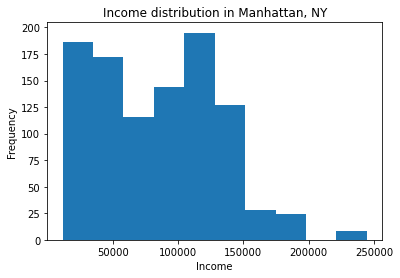

In [155]:
#geting histogram for income to better understand distribution 
income.Income.plot.hist()
plt.title('Income distribution in Manhattan, NY')
plt.xlabel('Income')

In [20]:
#since we are looking for high income neighborhood we will remove incomes that are under 100k
new_income=income[income.Income>=100000]
new_income

,Latitude,Longitude,Borough,Income,Georeference,Neighborhood,Suburb
3,40.699347,-74.010905,Manhattan,147500.0,"40.6993467337,-74.0109045226",Financial District,Manhattan
4,40.699347,-74.007739,Manhattan,147500.0,"40.6993467337,-74.0077386935",Financial District,Manhattan
5,40.699347,-74.004573,Manhattan,147500.0,"40.6993467337,-74.0045728643",Financial District,Manhattan
6,40.701608,-74.014070,Manhattan,147500.0,"40.7016080402,-74.0140703518",Financial District,Manhattan
7,40.701608,-74.010905,Manhattan,147500.0,"40.7016080402,-74.0109045226",Financial District,Manhattan
...,...,...,...,...,...,...,...
810,40.812412,-73.966583,Manhattan,111875.0,"40.812412060300005,-73.9665829146",Morningside Heights,Manhattan
811,40.812412,-73.963417,Manhattan,111875.0,"40.812412060300005,-73.9634170854",Morningside Heights,Manhattan
812,40.814673,-73.969749,Manhattan,111875.0,"40.8146733668,-73.9697487437",Morningside Heights,Manhattan
1001,40.855377,-73.934925,Manhattan,107727.0,"40.8553768844,-73.9349246231",Hudson Heights,Manhattan


In [21]:
#Now we are looking only into Neighborhoods with high income
new_income.Neighborhood.value_counts()

Upper West Side                59
Chelsea                        28
Financial District             21
Battery Park City              19
Lenox Hill                     18
Hudson Yards                   17
West Village                   16
Midtown East                   15
Hudson Square                  15
Hell's Kitchen                 14
Yorkville                      13
Morningside Heights            13
Upper East Side                13
Greenwich Village              12
Tribeca                        10
Turtle Bay                     10
Manhattan Community Board 8     9
Murray Hill                     9
Midtown                         9
Tudor City                      8
Carnegie Hill                   7
Midtown South                   7
Manhattan Valley                6
Flatiron District               6
Kips Bay                        5
Gramercy                        5
NoMad                           5
SoHo                            5
Lincoln Square                  4
Stuy Town     

In [22]:
# we want to use only Neighborhoods with high occurences of high incomes and will set treshold to 10 
n=new_income.Neighborhood.value_counts()
thresh = 10
high_income=new_income[new_income.Neighborhood.map(n).ge(thresh)].reset_index()
high_income

,index,Latitude,Longitude,Borough,Income,Georeference,Neighborhood,Suburb
0,3,40.699347,-74.010905,Manhattan,147500.0,"40.6993467337,-74.0109045226",Financial District,Manhattan
1,4,40.699347,-74.007739,Manhattan,147500.0,"40.6993467337,-74.0077386935",Financial District,Manhattan
2,5,40.699347,-74.004573,Manhattan,147500.0,"40.6993467337,-74.0045728643",Financial District,Manhattan
3,6,40.701608,-74.014070,Manhattan,147500.0,"40.7016080402,-74.0140703518",Financial District,Manhattan
4,7,40.701608,-74.010905,Manhattan,147500.0,"40.7016080402,-74.0109045226",Financial District,Manhattan
...,...,...,...,...,...,...,...,...
288,808,40.812412,-73.972915,Manhattan,111875.0,"40.812412060300005,-73.9729145729",Morningside Heights,Manhattan
289,809,40.812412,-73.969749,Manhattan,111875.0,"40.812412060300005,-73.9697487437",Morningside Heights,Manhattan
290,810,40.812412,-73.966583,Manhattan,111875.0,"40.812412060300005,-73.9665829146",Morningside Heights,Manhattan
291,811,40.812412,-73.963417,Manhattan,111875.0,"40.812412060300005,-73.9634170854",Morningside Heights,Manhattan


In [23]:
high_income.Neighborhood.value_counts()

Upper West Side        59
Chelsea                28
Financial District     21
Battery Park City      19
Lenox Hill             18
Hudson Yards           17
West Village           16
Midtown East           15
Hudson Square          15
Hell's Kitchen         14
Yorkville              13
Upper East Side        13
Morningside Heights    13
Greenwich Village      12
Tribeca                10
Turtle Bay             10
Name: Neighborhood, dtype: int64

### Now that we have list of neighborhoods with high incomes we can move to another dataset where we will look for the safest neirborhood based on NYPD arrest data

In [24]:
#loading NYPD arrest dataset
arrest_data=pd.read_csv('https://raw.githubusercontent.com/sivosevic/Coursera_Capstone/master/NYPD_Arrest_Data.csv')
arrest_data

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,218375425,09/26/2020,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,M,1,0,25-44,M,WHITE,982285,201682,40.720255,-74.007090,POINT (-74.00709027999993 40.72025522300004)
1,217319714,09/02/2020,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",113.0,FORGERY,PL 1702500,F,M,5,0,18-24,F,BLACK,983903,200257,40.716344,-74.001253,POINT (-74.00125319299997 40.71634415200003)
2,218282529,09/24/2020,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN",107.0,BURGLARY,PL 1402000,F,M,34,0,45-64,M,BLACK,1003633,253391,40.862161,-73.929927,POINT (-73.92992712599995 40.862161439000026)
3,217526617,09/07/2020,792.0,WEAPONS POSSESSION 1 & 2,118.0,DANGEROUS WEAPONS,PL 2650303,F,K,67,0,18-24,M,BLACK,1003029,176696,40.651655,-73.932325,POINT (-73.93232493699998 40.65165467100008)
4,218518385,09/29/2020,268.0,CRIMINAL MIS 2 & 3,121.0,CRIMINAL MISCHIEF & RELATED OF,PL 1450502,F,K,66,0,18-24,M,BLACK,988164,170927,40.635839,-73.985899,POINT (-73.98589935799998 40.635839049000026)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103371,206920909,01/04/2020,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1600500,F,K,81,0,45-64,M,BLACK,1001470,186937,40.679767,-73.937917,POINT (-73.937917165 40.67976710800008)
103372,206916505,01/03/2020,515.0,"CONTROLLED SUBSTANCE,SALE 3",117.0,DANGEROUS DRUGS,PL 2203901,F,B,46,0,25-44,M,WHITE HISPANIC,1007435,248210,40.847932,-73.916200,POINT (-73.91619988299993 40.84793197700003)
103373,206903442,01/02/2020,511.0,"CONTROLLED SUBSTANCE, POSSESSI",235.0,DANGEROUS DRUGS,PL 2200300,M,K,81,1,45-64,M,WHITE HISPANIC,1001284,193892,40.698857,-73.938570,POINT (-73.93857017799998 40.69885734300004)
103374,206918192,01/04/2020,681.0,"CHILD, ENDANGERING WELFARE",233.0,SEX CRIMES,PL 2601001,M,B,46,0,25-44,M,BLACK HISPANIC,1011881,250411,40.853960,-73.900121,POINT (-73.90012087499997 40.85396027400003)


In [25]:
arrest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103376 entries, 0 to 103375
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ARREST_KEY                103376 non-null  int64  
 1   ARREST_DATE               103376 non-null  object 
 2   PD_CD                     103362 non-null  float64
 3   PD_DESC                   103352 non-null  object 
 4   KY_CD                     103352 non-null  float64
 5   OFNS_DESC                 103352 non-null  object 
 6   LAW_CODE                  103376 non-null  object 
 7   LAW_CAT_CD                102406 non-null  object 
 8   ARREST_BORO               103376 non-null  object 
 9   ARREST_PRECINCT           103376 non-null  int64  
 10  JURISDICTION_CODE         103376 non-null  int64  
 11  AGE_GROUP                 103376 non-null  object 
 12  PERP_SEX                  103376 non-null  object 
 13  PERP_RACE                 103376 non-null  o

In [26]:
#checking number of arrests per Boro
arrest_data.ARREST_BORO.value_counts()

K    27962
M    24637
B    23963
Q    22316
S     4498
Name: ARREST_BORO, dtype: int64

### Since we need only information for Manhattan we will exclude all another Boroughs

In [27]:
#creating dataset where is Manhattan arrest boro,creating new Georeference column with lat and long and getting dataset with only needed columns 
manhattan_arrest = arrest_data[arrest_data['ARREST_BORO'] == 'M']
manhattan_arrest["Georeference"] =  manhattan_arrest["Latitude"].map(str)  + ',' + manhattan_arrest['Longitude'].map(str)
manhattan_arrest=manhattan_arrest[['ARREST_DATE', 'OFNS_DESC', 'ARREST_BORO','Latitude','Longitude','Georeference']]
manhattan_arrest


,ARREST_DATE,OFNS_DESC,ARREST_BORO,Latitude,Longitude,Georeference
0,09/26/2020,RAPE,M,40.720255,-74.007090,"40.72025522300004,-74.00709027999993"
1,09/02/2020,FORGERY,M,40.716344,-74.001253,"40.71634415200003,-74.00125319299997"
2,09/24/2020,BURGLARY,M,40.862161,-73.929927,"40.862161439000026,-73.92992712599995"
8,09/16/2020,BURGLARY,M,40.720464,-74.006852,"40.720463840000036,-74.00685220399998"
12,09/03/2020,BURGLAR'S TOOLS,M,40.744653,-74.006386,"40.74465339200003,-74.00638553999994"
...,...,...,...,...,...,...
103352,01/03/2020,FRAUDULENT ACCOSTING,M,40.758545,-73.977203,"40.75854522600008,-73.97720307199995"
103353,01/02/2020,CRIMINAL MISCHIEF & RELATED OF,M,40.722262,-74.005914,"40.72226170900007,-74.00591439799997"
103358,01/03/2020,FRAUDULENT ACCOSTING,M,40.758545,-73.977203,"40.75854522600008,-73.97720307199995"
103363,01/06/2020,ASSAULT 3 & RELATED OFFENSES,M,40.723810,-73.991805,"40.72380961300007,-73.99180465899997"


In [28]:
locator = Nominatim(user_agent="myGeocoder")
coordinates = "40.72226170900007,-74.00591439799997"
location = locator.reverse(coordinates)
location.raw

{'place_id': 52997523,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'node',
 'osm_id': 4464067133,
 'lat': '40.7225531',
 'lon': '-74.0062295',
 'display_name': 'Canal Street, Hudson Square, Manhattan Community Board 2, Manhattan, New York County, New York, 10005, United States',
 'address': {'railway': 'Canal Street',
  'road': 'Canal Street',
  'neighbourhood': 'Hudson Square',
  'suburb': 'Manhattan',
  'county': 'New York County',
  'city': 'New York',
  'state': 'New York',
  'postcode': '10005',
  'country': 'United States',
  'country_code': 'us'},
 'boundingbox': ['40.7225031', '40.7226031', '-74.0062795', '-74.0061795']}

In [29]:
#Using reverse Geocode we will create new column Neighborhood from Georeference info and will save data to csv
tqdm.pandas()
locator = Nominatim(user_agent="myGeocoder", timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)
manhattan_arrest['Neighborhood'] = manhattan_arrest['Georeference'].progress_apply(lambda x: dict_get(rgeocode(x).raw,'address.neighbourhood'))
manhattan_arrest.to_csv('processed_manhattan_arrest.csv',index=False)

100%|██████████| 24637/24637 [3:25:24<00:00,  2.00it/s]  


In [30]:
neigh_arrest=pd.read_csv('processed_manhattan_arrest.csv')
neigh_arrest

,ARREST_DATE,OFNS_DESC,ARREST_BORO,Latitude,Longitude,Georeference,Neighborhood
0,09/26/2020,RAPE,M,40.720255,-74.007090,"40.72025522300004,-74.00709027999993",Tribeca
1,09/02/2020,FORGERY,M,40.716344,-74.001253,"40.71634415200003,-74.00125319299997",Civic Center
2,09/24/2020,BURGLARY,M,40.862161,-73.929927,"40.862161439000026,-73.92992712599995",Fort George
3,09/16/2020,BURGLARY,M,40.720464,-74.006852,"40.720463840000036,-74.00685220399998",Tribeca
4,09/03/2020,BURGLAR'S TOOLS,M,40.744653,-74.006386,"40.74465339200003,-74.00638553999994",Chelsea
...,...,...,...,...,...,...,...
24632,01/03/2020,FRAUDULENT ACCOSTING,M,40.758545,-73.977203,"40.75854522600008,-73.97720307199995",Midtown
24633,01/02/2020,CRIMINAL MISCHIEF & RELATED OF,M,40.722262,-74.005914,"40.72226170900007,-74.00591439799997",Hudson Square
24634,01/03/2020,FRAUDULENT ACCOSTING,M,40.758545,-73.977203,"40.75854522600008,-73.97720307199995",Midtown
24635,01/06/2020,ASSAULT 3 & RELATED OFFENSES,M,40.723810,-73.991805,"40.72380961300007,-73.99180465899997",Lower East Side


In [31]:
#Missing values for Neighorhoods
print("There are {} missing values for Neighborhoods in data frame".format(neigh_arrest.Neighborhood.isnull().sum()))

There are 51 missing values for Neighborhoods in data frame


In [32]:
##Dropping the data where values for Neighborhoods are none 
neigh_arrest = neigh_arrest[~neigh_arrest.Neighborhood.isnull()]
neigh_arrest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24586 entries, 0 to 24636
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ARREST_DATE   24586 non-null  object 
 1   OFNS_DESC     24583 non-null  object 
 2   ARREST_BORO   24586 non-null  object 
 3   Latitude      24586 non-null  float64
 4   Longitude     24586 non-null  float64
 5   Georeference  24586 non-null  object 
 6   Neighborhood  24586 non-null  object 
dtypes: float64(2), object(5)
memory usage: 1.5+ MB


In [33]:
count_neigh = Counter(neigh_arrest.Neighborhood).most_common(65)
count_neigh

[('East Harlem', 3558),
 ('Harlem', 2295),
 ('Washington Heights', 1061),
 ('Lower East Side', 1013),
 ('Upper West Side', 864),
 ('Chelsea', 863),
 ("Hell's Kitchen", 818),
 ('Fort George', 738),
 ('West Village', 738),
 ('East Village', 684),
 ('Five Points', 669),
 ('Theater District', 656),
 ('Gramercy', 631),
 ('Manhattanville', 624),
 ('Greenwich Village', 563),
 ('Tribeca', 561),
 ('Lenox Hill', 555),
 ('Manhattan Valley', 555),
 ('Herald Square', 494),
 ('Hudson Yards', 491),
 ('Garment District', 406),
 ('Midtown', 397),
 ('Civic Center', 392),
 ('Turtle Bay', 385),
 ('Hamilton Heights', 371),
 ('Sugar Hill', 348),
 ('SoHo', 346),
 ('Financial District', 264),
 ('Yorkville', 245),
 ('Inwood', 243),
 ('Midtown East', 242),
 ('Upper East Side', 200),
 ('Alphabet City', 197),
 ('Kips Bay', 193),
 ('Morningside Heights', 189),
 ('Chinatown', 180),
 ('Flatiron District', 163),
 ('Hudson Heights', 146),
 ('Two Bridges', 132),
 ('Midtown South', 132),
 ('NoMad', 123),
 ('Carnegie Hil

### Since we are looking for safest neighbourhoods we will exclude all that have crime occurences higher than 300 


In [35]:
group_count=neigh_arrest.Neighborhood.value_counts()
thresh = 300
# replace the manufacturer with the counts and thresholding
low_crime=neigh_arrest[neigh_arrest.Neighborhood.map(group_count).le(thresh)].reset_index()
low_crime

,index,ARREST_DATE,OFNS_DESC,ARREST_BORO,Latitude,Longitude,Georeference,Neighborhood
0,17,09/29/2020,OFFENSES AGAINST PUBLIC ADMINI,M,40.863122,-73.920613,"40.863121541000055,-73.92061310099997",Inwood
1,38,09/01/2020,FOR OTHER AUTHORITIES,M,40.705519,-74.005137,"40.70551869900004,-74.00513745999997",Financial District
2,39,09/17/2020,ASSAULT 3 & RELATED OFFENSES,M,40.735560,-73.991464,"40.73555988900005,-73.99146402799995",Union Square
3,53,09/28/2020,PETIT LARCENY,M,40.776412,-73.948251,"40.77641236200003,-73.94825084599995",Yorkville
4,56,09/24/2020,CRIMINAL MISCHIEF & RELATED OF,M,40.706210,-74.004881,"40.70621039100007,-74.00488143099993",Financial District
...,...,...,...,...,...,...,...,...
3505,24578,01/03/2020,GRAND LARCENY,M,40.762235,-73.968188,"40.76223477100008,-73.96818808299997",Midtown East
3506,24591,01/04/2020,MISCELLANEOUS PENAL LAW,M,40.740825,-73.974261,"40.74082451100002,-73.97426085799998",Kips Bay
3507,24614,01/02/2020,MISCELLANEOUS PENAL LAW,M,40.721530,-73.982266,"40.721530390000055,-73.98226639799998",Alphabet City
3508,24631,01/05/2020,OTHER OFFENSES RELATED TO THEF,M,40.749755,-73.985615,"40.749755161000046,-73.98561539199994",Midtown South


In [37]:
low_crime.Neighborhood.value_counts()

Financial District              264
Yorkville                       245
Inwood                          243
Midtown East                    242
Upper East Side                 200
Alphabet City                   197
Kips Bay                        193
Morningside Heights             189
Chinatown                       180
Flatiron District               163
Hudson Heights                  146
Midtown South                   132
Two Bridges                     132
NoMad                           123
Carnegie Hill                   110
Union Square                     93
Hudson Square                    81
Columbus Circle                  70
Little Italy                     69
Murray Hill                      68
NoHo Historic District           58
NoHo                             53
Meatpacking District             41
Koreatown                        38
Rose Hill                        35
Lincoln Square                   32
Flower District                  26
Stuy Town                   

In [39]:
low_crime_neigh = pd.pivot_table(low_crime,
                               values=['ARREST_DATE'],
                               index=['Neighborhood'],
                               columns=['OFNS_DESC'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
low_crime_neigh

ARREST_DATE  \
OFNS_DESC                    ADMINISTRATIVE CODE   
Neighborhood                                       
Alphabet City                                  1   
Battery Park City                              0   
Carnegie Hill                                  0   
Chinatown                                      0   
Columbus Circle                                0   
DUMBO                                          0   
Financial District                             0   
Flatiron District                              0   
Flower District                                0   
Hudson Heights                                 0   
Hudson Square                                  0   
Inwood                                         0   
Kips Bay                                       0   
Koreatown                                      0   
Lincoln Square                                 0   
Little Italy                                   0   
Manhattan Community Board 11                   0   
Manhattan Community Board 7                    0   
Manhattan Community Board 8                    0   
Meatpacking District                           0   
Midtown East                                   0   
Midtown South                                  0   
Morningside Heights                            0   
Murray Hill                                    0   
NoHo                                           0   
NoHo Historic District                         0   
NoMad                                          0   
Rose Hill                                      0   
Stuy Town                                      0   
Tudor City                                     0   
Two Bridges                                    0   
Union Square                                   0   
University Village                             0   
Upper East Side                                0   
Washington Square Village                      0   
Yorkville                                      0   
All                                            1   

                                                                   \
OFNS_DESC                    AGRICULTURE & MRKTS LAW-UNCLASSIFIED   
Neighborhood                                                        
Alphabet City                                                   0   
Battery Park City                                               0   
Carnegie Hill                                                   0   
Chinatown                                                       0   
Columbus Circle                                                 0   
DUMBO                                                           0   
Financial District                                              0   
Flatiron District                                               0   
Flower District                                                 0   
Hudson Heights                                                  0   
Hudson Square                                                   0   
Inwood                                                          0   
Kips Bay                                                        0   
Koreatown                                                       0   
Lincoln Square                                                  0   
Little Italy                                                    0   
Manhattan Community Board 11                                    0   
Manhattan Community Board 7                                     0   
Manhattan Community Board 8                                     0   
Meatpacking District                                            0   
Midtown East                                                    0   
Midtown South                                                   0   
Morningside Heights                                             1   
Murray Hill                                                     0   
NoHo                                                            0   
NoHo Historic District  

Text(0, 0.5, 'Crime Frequency')

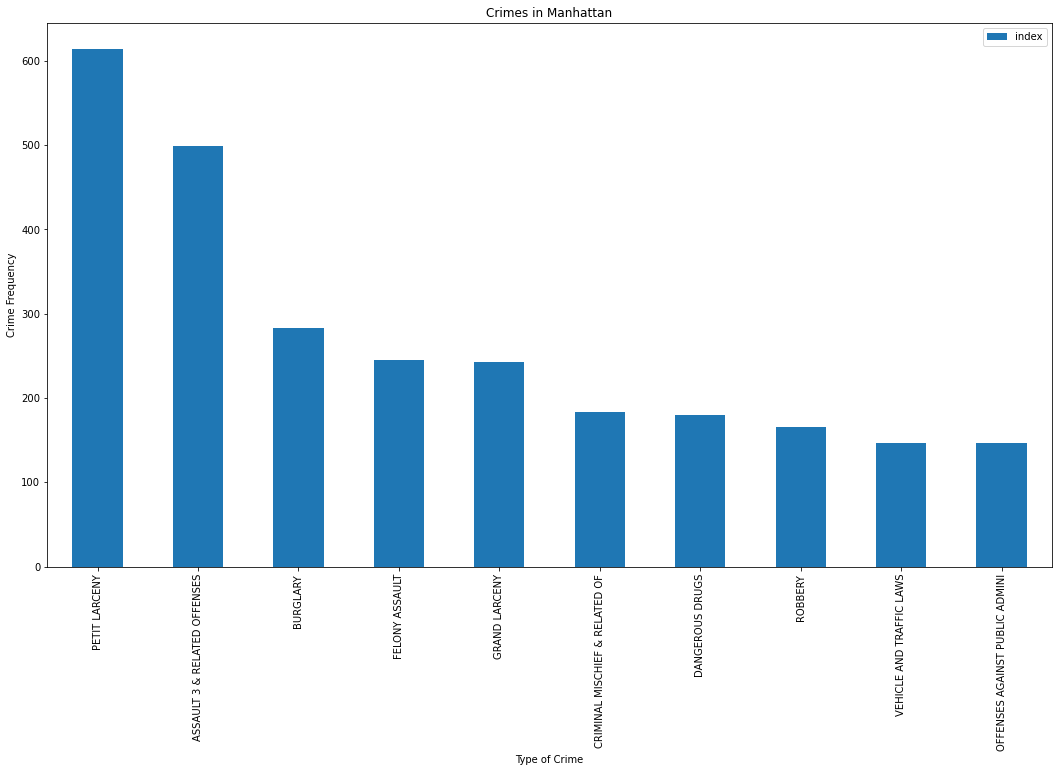

In [147]:
#visualy presenting top 10 crimes for low crime neirborhoods in Manhattan
crime_count = low_crime[['OFNS_DESC','index']].groupby('OFNS_DESC').count().sort_values(by='index',ascending=False).head(10)
crime_count.sort_values('index',axis=0, ascending=False, inplace=True)
ax3 = crime_count.plot(kind='bar', figsize=(18,10))
ax3.set_title('Crimes in Manhattan')
ax3.set_xlabel('Type of Crime')
ax3.set_ylabel('Crime Frequency')

### Now since we have list of Neihborhoods with low crime rate and high income, we want to find neighborhoods that are matching both of them 


In [41]:
#creating list of neighborhoods in low crime dataset
low_crime_list=list(low_crime.Neighborhood.unique())
low_crime_list

['Inwood',
 'Financial District',
 'Union Square',
 'Yorkville',
 'Flatiron District',
 'Meatpacking District',
 'Midtown East',
 'Battery Park City',
 'Morningside Heights',
 'Manhattan Community Board 11',
 'NoHo',
 'Murray Hill',
 'Upper East Side',
 'Chinatown',
 'Kips Bay',
 'Little Italy',
 'Two Bridges',
 'Carnegie Hill',
 'Alphabet City',
 'Lincoln Square',
 'Hudson Square',
 'Columbus Circle',
 'NoMad',
 'Midtown South',
 'Hudson Heights',
 'Tudor City',
 'Koreatown',
 'NoHo Historic District',
 'Manhattan Community Board 7',
 'Stuy Town',
 'Manhattan Community Board 8',
 'Flower District',
 'Rose Hill',
 'University Village',
 'DUMBO',
 'Washington Square Village']

In [42]:
#creating list of neighborhoods in high income dataset
high_income_list=list(high_income.Neighborhood.unique())
high_income_list

['Financial District',
 'Battery Park City',
 'Tribeca',
 'Hudson Square',
 'Greenwich Village',
 'West Village',
 'Chelsea',
 'Hudson Yards',
 'Turtle Bay',
 'Midtown East',
 "Hell's Kitchen",
 'Lenox Hill',
 'Upper East Side',
 'Upper West Side',
 'Yorkville',
 'Morningside Heights']

In [43]:
#here we will compare two list and get names of Neighborhoods that are maching both datasets
common_neighborhoods=set(low_crime_list).intersection(high_income_list)
common_neighborhoods

{'Battery Park City',
 'Financial District',
 'Hudson Square',
 'Midtown East',
 'Morningside Heights',
 'Upper East Side',
 'Yorkville'}

#### In this part we will import another dataset that contain informations about NYC boroughs and their neighborhoods.


In [121]:
import requests, json

content = requests.get("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json")
NY_data = json.loads(content.content)
NY_data['features'][0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Here we are going to create new Data frame that contains Borough, Neighborhood ,Latitude and Longitude

In [122]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods_data = NY_data['features']
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [123]:
#cheking numer of neighborhoods  ber borough 
neighborhoods.Borough.value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64

#### Now we will use common neighborhoods and create new data frame with their Latitude and Longitude informations

In [124]:
#Creating dataframe with common neighborhoods from low crime and high income with their Latitude and Longitude
common_neighborhoods=['Battery Park City','Financial District','Hudson Yards','Midtown','Morningside Heights','Upper East Side',
 'Yorkville']
final_data=neighborhoods.loc[neighborhoods['Neighborhood'].isin(common_neighborhoods)].reset_index()
final_data

,index,Borough,Neighborhood,Latitude,Longitude
0,107,Manhattan,Upper East Side,40.775639,-73.960508
1,108,Manhattan,Yorkville,40.775930,-73.947118
2,114,Manhattan,Midtown,40.754691,-73.981669
3,125,Manhattan,Morningside Heights,40.808000,-73.963896
4,127,Manhattan,Battery Park City,40.711932,-74.016869
5,128,Manhattan,Financial District,40.707107,-74.010665
6,301,Manhattan,Hudson Yards,40.756658,-74.000111


#### Here we gonna use geopy library to get the latitude and longitude values of Manhattan

In [125]:
#get coordinates for  Manhattan
address = 'Manhattan, NY'
geolocator = Nominatim(user_agent="nyc_Geocoder")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


### In this part we are going to start utilizing the Foursquare API to explore the venues is neighborhoods 

In [126]:
#Defining Foursquare Credentials 
CLIENT_ID = 'YOUR_ID' # your Foursquare ID
CLIENT_SECRET = 'YOUR_SECRET' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SD4M1NFEHDZ1L2Y0NJ0KIIDZWJJ2MCNWECEWCP1T3KP23LE0
CLIENT_SECRET:O15H4LH4WEXUUVTJQZB3VENYGNVDYRZQUN4DXLH4OLTGRA4W


In [127]:
#creating function that will be used to extract venues informaions based on neighborhood latitude and longitude
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [128]:
#applying get venues function to create new df with neighborhood venues
Neighborhood_venues = getNearbyVenues(names=final_data['Neighborhood'],
                                   latitudes=final_data['Latitude'],
                                   longitudes=final_data['Longitude'])

Upper East Side
Yorkville
Midtown
Morningside Heights
Battery Park City
Financial District
Hudson Yards


In [129]:
#cheking the size of df
print(Neighborhood_venues.shape)
Neighborhood_venues.head()

(583, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Upper East Side,40.775639,-73.960508,Lady M Cake Boutique,40.775619,-73.962186,Bakery
1,Upper East Side,40.775639,-73.960508,Sant Ambroeus,40.775328,-73.962819,Italian Restaurant
2,Upper East Side,40.775639,-73.960508,Dos Toros Taqueria,40.773950,-73.959668,Burrito Place
3,Upper East Side,40.775639,-73.960508,Aēsop,40.777584,-73.961499,Cosmetics Shop
4,Upper East Side,40.775639,-73.960508,The Mark Hotel,40.775274,-73.963383,Hotel


In [130]:
#getting number of venues per neirborhood
Neighborhood_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,73,73,73,73,73,73
Financial District,100,100,100,100,100,100
Hudson Yards,71,71,71,71,71,71
Midtown,100,100,100,100,100,100
Morningside Heights,40,40,40,40,40,40
Upper East Side,99,99,99,99,99,99
Yorkville,100,100,100,100,100,100


In [131]:
#here we going to see how many diferent categories are there 
print('There are {} uniques categories.'.format(len(Neighborhood_venues['Venue Category'].unique())))

There are 164 uniques categories.


### In this part we are goint to analyze each neighborhood
#### We gonna start off using one hot encoding where we make each venue be the function of every category in the dataset, a category takes the value of 0 if the venue does not belong in the category and 1 if it does.

In [132]:
# one hot encoding
manhattan_onehot = pd.get_dummies(Neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = Neighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Bagel Shop,...,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Upper East Side,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Upper East Side,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Upper East Side,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Upper East Side,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Upper East Side,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
manhattan_onehot.shape

(583, 165)

In [134]:
#here we are calculating mean for each venue 
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Bagel Shop,...,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Battery Park City,0.000000,0.000000,0.000000,0.000,0.000000,0.013699,0.013699,0.013699,0.00,...,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.013699,0.000000,0.000000
1,Financial District,0.030000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.01,...,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.010000,0.010000,0.010000
2,Hudson Yards,0.056338,0.014085,0.000000,0.000,0.014085,0.014085,0.000000,0.000000,0.00,...,0.014085,0.014085,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000
3,Midtown,0.030000,0.010000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.040000,0.000000,0.01,0.00,0.00,0.00,0.000000,0.010000,0.000000
4,Morningside Heights,0.075000,0.000000,0.000000,0.025,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000
5,Upper East Side,0.040404,0.010101,0.010101,0.000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.010101,0.000000,0.010101,0.00,0.00,0.00,0.00,0.020202,0.020202,0.030303
6,Yorkville,0.000000,0.000000,0.000000,0.000,0.010000,0.010000,0.000000,0.000000,0.02,...,0.010000,0.000000,0.000000,0.00,0.01,0.02,0.01,0.030000,0.000000,0.000000


In [135]:
#sorting venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Here we are going to create the new dataframe and display the top 10 venues for each neighborhood.


In [136]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Clothing Store,Gym,Boat or Ferry,Memorial Site,Plaza,Food Court,Burger Joint
1,Financial District,Coffee Shop,Bar,American Restaurant,Café,Gym / Fitness Center,Italian Restaurant,Gym,Cocktail Bar,Pizza Place,Sandwich Place
2,Hudson Yards,Gym / Fitness Center,American Restaurant,Italian Restaurant,Hotel,Café,Gym,Dog Run,Park,Restaurant,Coffee Shop
3,Midtown,Hotel,Clothing Store,Coffee Shop,Steakhouse,Theater,American Restaurant,Bakery,Bookstore,Gym,Sporting Goods Shop
4,Morningside Heights,Coffee Shop,Park,Bookstore,American Restaurant,Café,Burger Joint,Arts & Crafts Store,New American Restaurant,Sandwich Place,Salad Place
5,Upper East Side,Coffee Shop,Italian Restaurant,Exhibit,Bakery,Gym / Fitness Center,American Restaurant,Spa,French Restaurant,Hotel,Juice Bar
6,Yorkville,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega,Sushi Restaurant,Japanese Restaurant,Diner,Wine Shop,Pharmacy


### Now we are going to use K-mean cluster to cluster neighborhood data
#### We will start off with determing what would be the best k value to use. Will be using The Elbow method and Silhouette score to determine what would be the best K value

### The Elbow method

#### The Elbow method depends on a calculated value called inertia, which is the sum of the squared distances between each point and its closest K-means center. If K is 1, then the inertia will equal the sum of all squared distances to the dataset’s mean.

In [137]:
# INERTIA
k_values = range(2,7)
inertia_values = [KMeans(k).fit(final_data[['Latitude','Longitude']]).inertia_
                  for k in k_values]

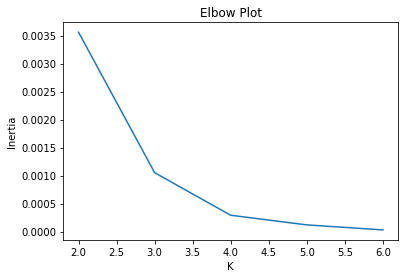

In [138]:
# A PLOT OF THE INERTIA VALUES TO DECIDE WITH K TO USE (ELBOW PLOT)
import matplotlib.pyplot as plt
plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

### The Silhouette score

#### Silhouette score captures the distance of each point to neighboring clusters.It can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of -1, 1.Higher Silhouette score would indicate optimal K value.


In [148]:
# here I'm gonna use silhouette_score to determine best K value
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = range(2,7)

for k in range_n_clusters:
    cluster_model = KMeans(n_clusters=k, random_state=10)
    cluster_labels = cluster_model.fit_predict(final_data[['Latitude','Longitude']])
    silhouette_avg = silhouette_score(final_data[['Latitude','Longitude']], cluster_labels)
    print("For k =", k,
          "The average silhouette_score is :", silhouette_avg)

For k = 2 The average silhouette_score is : 0.5798684311015216
For k = 3 The average silhouette_score is : 0.5958543699923677
For k = 4 The average silhouette_score is : 0.5734181433629942
For k = 5 The average silhouette_score is : 0.4086420303922939
For k = 6 The average silhouette_score is : 0.24004614785120212


### Based on elbow method and best silhouette_score optimal K value is 3

In [140]:
# set number of clusters
kclusters = 3

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 0, 2, 1, 1], dtype=int32)

In [141]:
# add clustering labels into df
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [142]:
#here we are going to joun neighborhood data with assigned clusters
manhattan_merged = final_data
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head(10)

,index,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,107,Manhattan,Upper East Side,40.775639,-73.960508,1,Coffee Shop,Italian Restaurant,Exhibit,Bakery,Gym / Fitness Center,American Restaurant,Spa,French Restaurant,Hotel,Juice Bar
1,108,Manhattan,Yorkville,40.775930,-73.947118,1,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega,Sushi Restaurant,Japanese Restaurant,Diner,Wine Shop,Pharmacy
2,114,Manhattan,Midtown,40.754691,-73.981669,0,Hotel,Clothing Store,Coffee Shop,Steakhouse,Theater,American Restaurant,Bakery,Bookstore,Gym,Sporting Goods Shop
3,125,Manhattan,Morningside Heights,40.808000,-73.963896,2,Coffee Shop,Park,Bookstore,American Restaurant,Café,Burger Joint,Arts & Crafts Store,New American Restaurant,Sandwich Place,Salad Place
4,127,Manhattan,Battery Park City,40.711932,-74.016869,0,Park,Coffee Shop,Hotel,Clothing Store,Gym,Boat or Ferry,Memorial Site,Plaza,Food Court,Burger Joint
5,128,Manhattan,Financial District,40.707107,-74.010665,1,Coffee Shop,Bar,American Restaurant,Café,Gym / Fitness Center,Italian Restaurant,Gym,Cocktail Bar,Pizza Place,Sandwich Place
6,301,Manhattan,Hudson Yards,40.756658,-74.000111,1,Gym / Fitness Center,American Restaurant,Italian Restaurant,Hotel,Café,Gym,Dog Run,Park,Restaurant,Coffee Shop


#### Here we will use folium map to visualize clusters on Manhattan

In [143]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Next, we will closely look into each cluster

#### First cluster

In [144]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[2] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Midtown,0,Hotel,Clothing Store,Coffee Shop,Steakhouse,Theater,American Restaurant,Bakery,Bookstore,Gym,Sporting Goods Shop
4,Battery Park City,0,Park,Coffee Shop,Hotel,Clothing Store,Gym,Boat or Ferry,Memorial Site,Plaza,Food Court,Burger Joint


#### From the first cluster we can see that neighborhoods Midtown and Battery Park City are clustered together. Looking closer into venues we can see that both of them have a Gym listed in top 10 venues. 

#### Second cluster

In [145]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[2] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Upper East Side,1,Coffee Shop,Italian Restaurant,Exhibit,Bakery,Gym / Fitness Center,American Restaurant,Spa,French Restaurant,Hotel,Juice Bar
1,Yorkville,1,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega,Sushi Restaurant,Japanese Restaurant,Diner,Wine Shop,Pharmacy
5,Financial District,1,Coffee Shop,Bar,American Restaurant,Café,Gym / Fitness Center,Italian Restaurant,Gym,Cocktail Bar,Pizza Place,Sandwich Place
6,Hudson Yards,1,Gym / Fitness Center,American Restaurant,Italian Restaurant,Hotel,Café,Gym,Dog Run,Park,Restaurant,Coffee Shop


#### Neighborhoods Upper East Side,Yorkville,Financial District and Hudson Yards were clustered together in second cluster. We also  notice that all of them contains Gym in top 10 venues.

#### Third cluster

In [146]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[2] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Morningside Heights,2,Coffee Shop,Park,Bookstore,American Restaurant,Café,Burger Joint,Arts & Crafts Store,New American Restaurant,Sandwich Place,Salad Place


#### In the third cluster we have only one Neighborhood:Morningside Heights. Taking a closer look into venues we can see that this is the only cluster that does not have a Gym in 10 most common venues.


#### In this project we were looking to find an optimal location to open exclusive gym. Our approach was to evaluate Manhattan neighborhoods based on income and crime rate. Once we had neighborhoods with high income and low crime rate, we used Foursquare API to get most common venues in those areas. We applied k mean cluster to cluster neighborhoods and use folium map to visualize them on Manhattan map. Analyzing each cluster, we concluded that third cluster that contains neighborhood Morningside Heights would be an optimal location to open an exclusive gym.